In [ ]:
import os
from dotenv import load_dotenv
import huggingface_hub

# load env var huggingface token
load_dotenv(os.path.join("../", ".env"))
# login to the hub
huggingface_hub.login(token=os.getenv("HUGGINGFACE_TOKEN"))

In [ ]:
import datasets

voxpopuli = datasets.load_dataset(
    "facebook/voxpopuli", "en", streaming=True, trust_remote_code=True
)

In [ ]:
voxpopuli_head = list(voxpopuli["train"].take(5))
SAMPLING_RATE = voxpopuli_head[0]["audio"]["sampling_rate"]
print(voxpopuli_head)

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoFeatureExtractor,
    SpeechEncoderDecoderModel,
    SpeechEncoderDecoderConfig,
    AutoConfig,
)

import torch

encoder_id = "facebook/wav2vec2-base-960h"  # acoustic model encoder
decoder_id = "facebook/bart-base"  # text decoder

# feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_id)
# tokenizer = AutoTokenizer.from_pretrained(decoder_id)

model = SpeechEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_id, decoder_id, encoder_add_adapter=True
)
model.config.encoder.feat_proj_dropout = 0.0
model.config.encoder.mask_time_prob = 0.0
model.config.decoder_start_token_id = model.decoder.config.bos_token_id
model.config.pad_token_id = model.decoder.config.pad_token_id
model.config.eos_token_id = model.decoder.config.eos_token_id
model.config.max_length = 128
model.config.encoder.layerdrop = 0.0
model.config.use_cache = False
model.config.processor_class = "Wav2Vec2Processor"

# Load model without pretrained weights
config_encoder = AutoConfig.from_pretrained(encoder_id)
config_encoder.add_adapter = True
config_decoder = AutoConfig.from_pretrained(decoder_id)
config_decoder.is_decoder = True
config_decoder.add_cross_attention = True

config = SpeechEncoderDecoderConfig.from_encoder_decoder_configs(
    config_encoder, config_decoder
)
model_no_weights = SpeechEncoderDecoderModel(config=config)

model_no_weights.config.encoder.feat_proj_dropout = 0.0
model_no_weights.config.encoder.mask_time_prob = 0.0
model_no_weights.config.decoder_start_token_id = (
    model_no_weights.decoder.config.bos_token_id
)
model_no_weights.config.pad_token_id = model_no_weights.decoder.config.pad_token_id
model_no_weights.config.eos_token_id = model_no_weights.decoder.config.eos_token_id
model_no_weights.config.max_length = 128
model_no_weights.config.encoder.layerdrop = 0.0
model_no_weights.config.use_cache = False
model_no_weights.config.processor_class = "Wav2Vec2Processor"

# # Accessing the model configuration
# config_encoder = model_no_weights.config.encoder
# config_encoder.add_adapter = True
# config_decoder = model_no_weights.config.decoder
# # set decoder config to causal lm
# config_decoder.is_decoder = True
# config_decoder.add_cross_attention = True


# input_values = feature_extractor(
#     voxpopuli_head[0]["audio"]["array"], return_tensors="pt", sampling_rate=SAMPLING_RATE
# ).input_values

# generated_ids = model.generate(input_values, decoder_start_token_id=tokenizer.cls_token_id, )
# generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
# print(generated_text)

# # load its corresponding transcription and tokenize to generate labels
# labels = tokenizer(voxpopuli_head[0]["text"], return_tensors="pt").input_ids

In [ ]:
from transformers import SpeechEncoderDecoderModel, AutoFeatureExtractor, AutoTokenizer
import torch


encoder_id = "facebook/wav2vec2-base"
decoder_id = "facebook/bart-base"
SAVE_PATH = "../../seq2seq_wav2vec2_bart-base"

model = SpeechEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_id, decoder_id, encoder_add_adapter=True
)
model.config.encoder.feat_proj_dropout = 0.0
model.config.encoder.mask_time_prob = 0.0
model.config.decoder_start_token_id = model.decoder.config.bos_token_id
model.config.pad_token_id = model.decoder.config.pad_token_id
model.config.eos_token_id = model.decoder.config.eos_token_id
model.config.max_length = 128
model.config.encoder.layerdrop = 0.0
model.config.use_cache = False
model.config.processor_class = "Wav2Vec2Processor"

# check if generation works
# _ = model.generate(torch.ones((1, 2000)))

model.save_pretrained(SAVE_PATH)

feature_etxractor = AutoFeatureExtractor.from_pretrained(encoder_id)
feature_etxractor.save_pretrained(SAVE_PATH)
tokenizer = AutoTokenizer.from_pretrained(decoder_id)
tokenizer.save_pretrained(SAVE_PATH)

In [ ]:
# Load trained model
def display_weight_stats(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            mean = param.data.mean().item()
            std = param.data.std().item()
            print(f"Layer: {name}\t| Mean: {mean:.4f}\t| Std: {std:.4f}")
        else:
            print(f"Layer: {name}\t| No gradients")


def count_parameters(model):
    encoder_params = (
        sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)
        if hasattr(model, "encoder")
        else 0
    )
    decoder_params = (
        sum(p.numel() for p in model.decoder.parameters() if p.requires_grad)
        if hasattr(model, "decoder")
        else 0
    )
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return encoder_params, decoder_params, total_params

In [ ]:
from transformers import AutoModelForSpeechSeq2Seq

model = AutoModelForSpeechSeq2Seq.from_pretrained("../seq2seq_wav2vec2_bart-base")

In [ ]:
enc, dec, total = count_parameters(model)
print(f"Encoder: {enc}\t| Decoder: {dec}\t| Total: {total}")
model

In [ ]:
display_weight_stats(model)

In [ ]:
# FOR DEBUGGING TO INSPECT THE AUDIO
import matplotlib.pyplot as plt
import librosa.display

# Load and display the original audio
audio_orig, sr_orig = librosa.load("../tmp/debug/2277-149896-0000_orig.mp3")
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_orig, sr=sr_orig)
plt.title("Original Audio")
plt.show()

# Load and display the post-feature extracted audio
audio_post, sr_post = librosa.load("../tmp/debug/2277-149896-0000.mp3")
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_post, sr=sr_post)
plt.title("Post-Feature Extracted Audio")
plt.show()

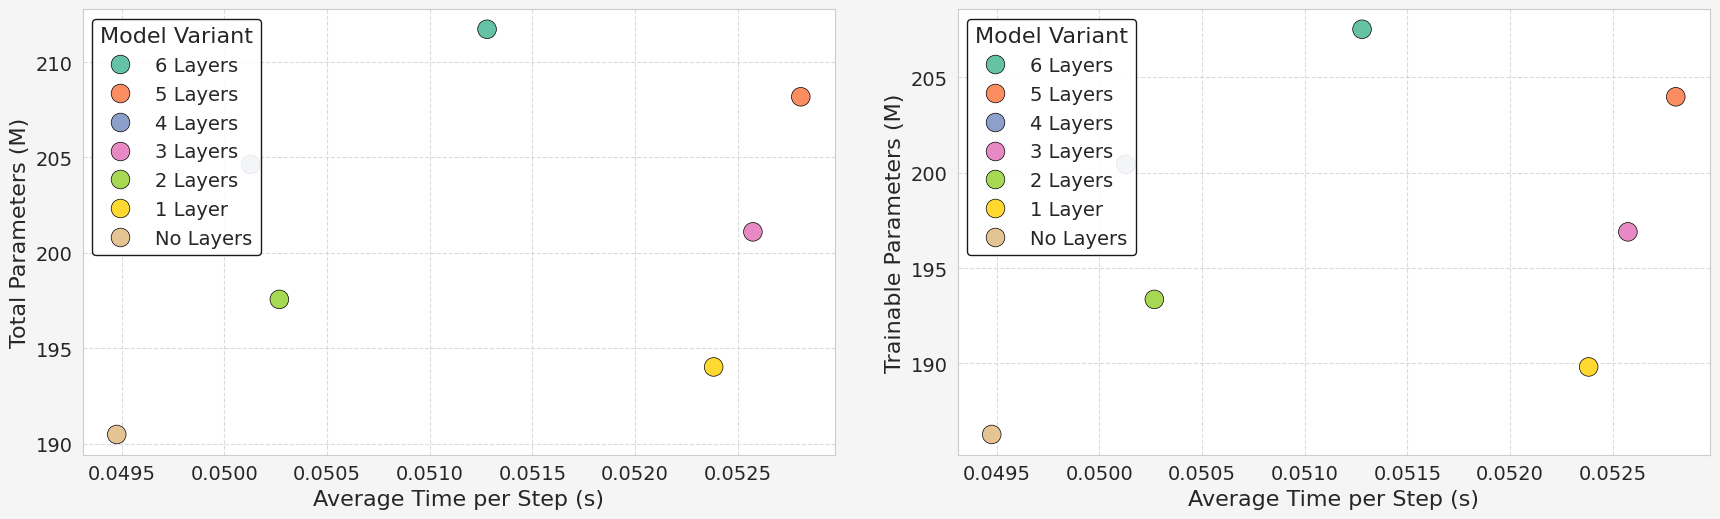

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data from CSV files
df_total = pd.read_csv("total_params_vox.csv")
df_total["Total parameters"] = (
    df_total["Total parameters"] / 1_000_000
)  # Convert to millions

df_trainable = pd.read_csv("train_params_vox.csv")
df_trainable["Trainable parameters"] = (
    df_trainable["Trainable parameters"] / 1_000_000
)  # Convert to millions

# Set seaborn style with enhancements
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Set font parameters for LaTeX compatibility
plt.rcParams.update(
    {
        "font.size": 18,  # Base font size
        "axes.titlesize": 18,  # Title font size (increased for consistency)
        "axes.labelsize": 16,  # Axis label font size (increased for consistency)
        "xtick.labelsize": 14,  # X tick label size (increased for readability)
        "ytick.labelsize": 14,  # Y tick label size (increased for readability)
        "legend.fontsize": 14,  # Legend font size (increased for readability)
        "legend.title_fontsize": 16,  # Legend title font size (increased for consistency)
    }
)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# Plot for Total Parameters
scatter1 = sns.scatterplot(
    data=df_total,
    x="Time per step",
    y="Total parameters",
    hue="name",
    s=180,  # Slightly reduced point size
    alpha=1,
    edgecolor="black",
    linewidth=0.5,
    ax=ax1,
    legend="brief",
)

# Plot for Trainable Parameters
scatter2 = sns.scatterplot(
    data=df_trainable,
    x="Time per step",
    y="Trainable parameters",
    hue="name",
    s=180,
    alpha=1,
    edgecolor="black",
    linewidth=0.5,
    ax=ax2,
    legend="brief",
)

# Customize axes
ax1.set_xlabel("Average Time per Step (s)")
ax1.set_ylabel("Total Parameters (M)")
ax1.grid(True, linestyle="--", alpha=0.7)

ax2.set_xlabel("Average Time per Step (s)")
ax2.set_ylabel("Trainable Parameters (M)")
ax2.grid(True, linestyle="--", alpha=0.7)

# Get handles and labels from the plots
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Remove the auto-generated legends first
ax1.get_legend().remove()
ax2.get_legend().remove()

# Add legend to the first plot (ax1)
ax1.legend(
    handles=handles1,
    labels=labels1,
    title="Model Variant",
    loc="upper left",
    frameon=True,
    edgecolor="black",
    facecolor="white",
    framealpha=0.9,
)

# Add legend to the second plot (ax2)
ax2.legend(
    handles=handles2,
    labels=labels2,
    title="Model Variant",
    loc="upper left",
    frameon=True,
    edgecolor="black",
    facecolor="white",
    framealpha=0.9,
)

# Adjust layout with extra padding
plt.tight_layout(pad=2.0)

# Add subtle background color
fig.patch.set_facecolor("#f5f5f5")

# Display the plot
plt.show()

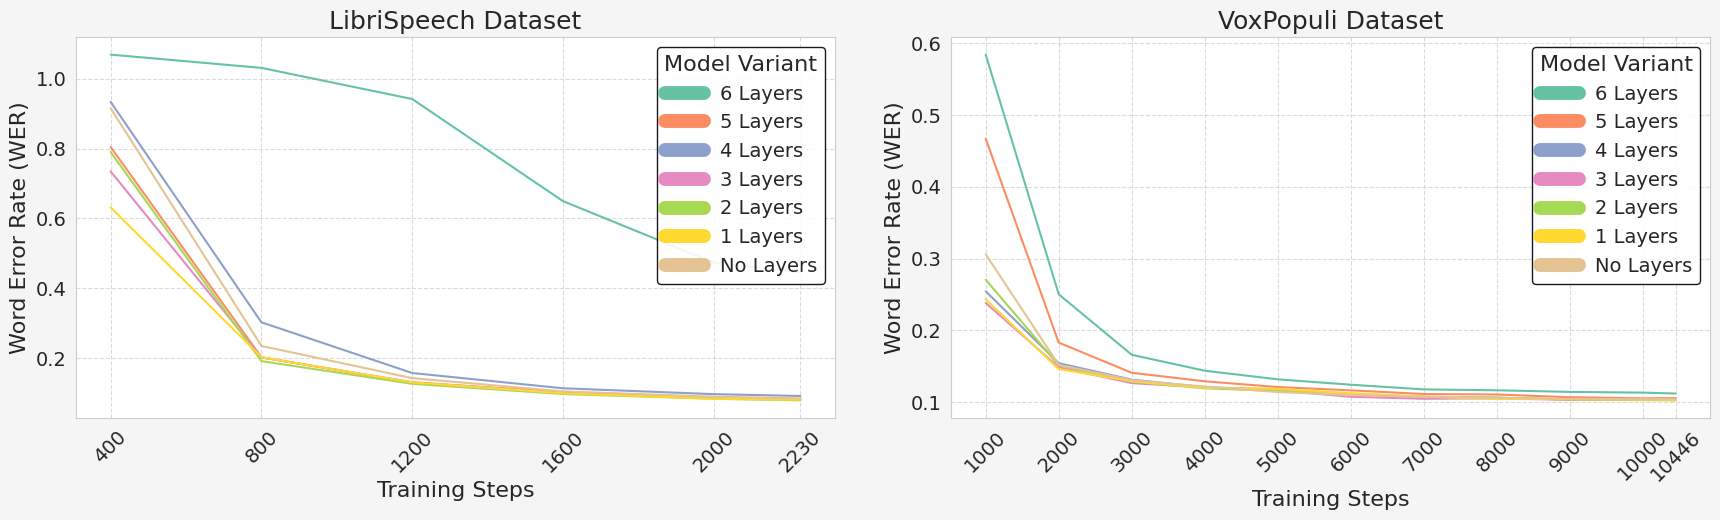

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load your CSV data
df_libri = pd.read_csv("wer_libri.csv")
df_vox = pd.read_csv("wer_vox.csv")

# Define prefixes
libri_prefix = (
    "librispeech_asr_clean_split-train.100_wav2vec2-bart_bs64_lr0.0003_ep5.0_"
)
vox_prefix = "facebook/voxpopuli_en_split-train_wav2vec2-bart_bs96_lr0.0001_ep6.0_"

# Define runs for both datasets
runs = {
    "6 Layers": {"suffix": "a64x"},
    "5 Layers": {"suffix": "a32x"},
    "4 Layers": {"suffix": "a16x"},
    "3 Layers": {"suffix": "a8x"},
    "2 Layers": {"suffix": "a4x"},
    "1 Layers": {"suffix": "a2x"},
    "No Layers": {"suffix": "noa"},
}


# Function to prepare data
def prepare_plot_data(df, prefix):
    plot_df = df[["train/global_step"]].copy()
    for label, info in runs.items():
        wer_col = f"{prefix}{info['suffix']} - eval/wer"
        dev_wer_col = f"{prefix}{info['suffix']} - eval/dev_wer"
        plot_df[label] = df[wer_col]

        # Replace last step with dev_wer
        final_step = df["train/global_step"].max()
        last_index = plot_df["train/global_step"].idxmax()
        dev_wer_value = df[dev_wer_col].iloc[-1]
        plot_df.loc[last_index, label] = (
            dev_wer_value if pd.notna(dev_wer_value) else None
        )
    return plot_df


# Prepare data for both datasets
plot_df_libri = prepare_plot_data(df_libri, libri_prefix)
plot_df_vox = prepare_plot_data(df_vox, vox_prefix)

# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Set font parameters
plt.rcParams.update(
    {
        "font.size": 18,
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "legend.title_fontsize": 16,
    }
)

# Create figure with two subplots side by side (removed sharey=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))


# Function to create plot
def create_plot(ax, plot_df, title):
    for label in runs.keys():
        sns.lineplot(
            data=plot_df,
            x="train/global_step",
            y=label,
            label=label,
            linewidth=1.5,
            alpha=1,
            ax=ax,
        )

    ax.set_xlabel("Training Steps")
    ax.set_ylabel("Word Error Rate (WER)")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.7)

    # Set x-axis ticks
    xticks = list(plot_df["train/global_step"])
    xticklabels = [str(x) for x in plot_df["train/global_step"]]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=45)

    # Customize legend
    leg = ax.legend(
        title="Model Variant",
        loc="upper right",
        frameon=True,
        edgecolor="black",
        facecolor="white",
        framealpha=0.9,
    )
    for line in leg.get_lines():
        line.set_linewidth(10.0)


# Create plots
create_plot(ax1, plot_df_libri, "LibriSpeech Dataset")
create_plot(ax2, plot_df_vox, "VoxPopuli Dataset")

# Adjust layout
plt.tight_layout(pad=2.0)
fig.patch.set_facecolor("#f5f5f5")

# Display the plot
plt.show()